In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

In [2]:
# ---------------------------
# Load all sheets from the Excel file
# ---------------------------
file_path = "uber_hackathon_v2_mock_data.xlsx"
sheets = pd.read_excel(file_path, sheet_name=None)

# Assign sheets to variables
earners = sheets['earners']
rides_trips = sheets['rides_trips']
earnings_daily = sheets['earnings_daily']
incentives_weekly = sheets['incentives_weekly']
cancellation_rates = sheets['cancellation_rates']
surge_by_hour = sheets.get('surge_by_hour')        # optional
weather_daily = sheets.get('weather_daily')        # optional
heatmap_sheet = sheets.get('heatmap')              # optional
jobs_like = sheets.get('jobs_like')                # optional

# Convert datetime columns
rides_trips['start_time'] = pd.to_datetime(rides_trips['start_time'])
rides_trips['end_time'] = pd.to_datetime(rides_trips['end_time'])
earnings_daily['date'] = pd.to_datetime(earnings_daily['date'])

print(f"Loaded {len(sheets)} sheets from {file_path}")
print(f"\nEarners: {len(earners)} records")
print(f"Rides/Trips: {len(rides_trips)} records")
print(f"Daily Earnings: {len(earnings_daily)} records")
print(f"Weekly Incentives: {len(incentives_weekly)} records")

Loaded 14 sheets from uber_hackathon_v2_mock_data.xlsx

Earners: 360 records
Rides/Trips: 3000 records
Daily Earnings: 5270 records
Weekly Incentives: 3622 records


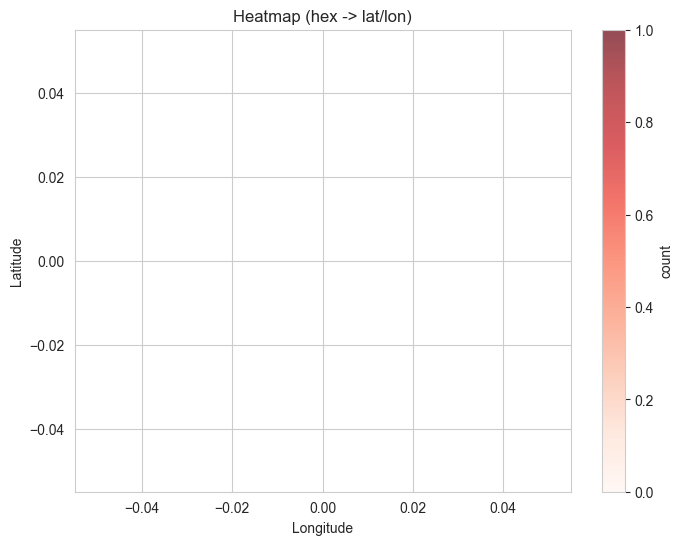

In [ ]:
# heatmapdf = heatmap_sheet.groupby(['msg.city_id', 'msg.map_id'])['species']
# --- H3 hex -> lat/lon conversion + quick heatmap ---
# This cell converts H3 hex ids in `heatmap_sheet['msg.map_id']` to latitude/longitude
# and plots a simple aggregated heatmap (scatter with point size/color by count).
# It will print an install hint if the `h3` package is not available.



try:
    import h3
    # from h3 import h3 as h3lib
except Exception as e:
    print("h3 library not installed. To install, run: pip install h3")
    # stop further execution of this cell when h3 is missing
    raise

# Ensure heatmap sheet exists
if heatmap_sheet is None:
    print("No 'heatmap' sheet found in the workbook.")
else:
    # Copy to avoid SettingWithCopy warnings
    df_h = heatmap_sheet.copy()

    # Normalize column name: try to find where the hex id lives
    # Common column names from dataset: 'msg.map_id', 'map_id', 'hex_id'
    possible_cols = ['msg.map_id', 'map_id', 'hex_id']
    hex_col = None
    for c in possible_cols:
        if c in df_h.columns:
            hex_col = c
            break
    if hex_col is None:
        # fallback: try any column containing 'map' or 'hex'
        for c in df_h.columns:
            if 'map' in c or 'hex' in c:
                hex_col = c
                break
    if hex_col is None:
        raise ValueError("Could not find a hex id column in heatmap sheet. Columns: {}".format(list(df_h.columns)))

    # Convert H3 to (lat, lon)
    def hex_to_latlon(h):
        try:
            lat, lon = h3.h3_to_geo(h)
            return lat, lon
        except Exception:
            return None, None

    coords = df_h[hex_col].astype(str).map(lambda x: hex_to_latlon(x))
    df_h['lat'] = coords.map(lambda t: t[0])
    df_h['lon'] = coords.map(lambda t: t[1])

    # Drop rows where conversion failed
    df_h = df_h.dropna(subset=['lat', 'lon'])

    # Aggregate counts per hex (or per lat/lon) for plotting
    agg = df_h.groupby(hex_col).size().reset_index(name='count')
    # join back a representative lat/lon for each hex
    rep = df_h.groupby(hex_col).agg({'lat':'first','lon':'first'}).reset_index()
    agg = agg.merge(rep, on=hex_col)

    # Quick scatter heatmap using seaborn/matplotlib
    plt.figure(figsize=(8,6))
    sc = plt.scatter(agg['lon'], agg['lat'], c=agg['count'], s=(agg['count']**0.6)*50, cmap='Reds', alpha=0.7)
    plt.colorbar(sc, label='count')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Heatmap (hex -> lat/lon)')
    plt.grid(True)
    plt.show()